In [1]:
import fiftyone as fo
import numpy as np
import torch
import torch.functional as F
from easyfsl.samplers import TaskSampler
from easyfsl.utils import plot_images, sliding_average
from matplotlib import pyplot as plt
from MulticoreTSNE import MulticoreTSNE as TSNE
from PIL import Image
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.models import resnet18
from tqdm import tqdm

from app.model import PrototypicalNetworks

/home/andre/miniconda3/envs/ml/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def plot_classes(model):
    dataset = fo.load_dataset('Felines')

    transform = transforms.Compose([transforms.ToTensor(),])

    map_to_id = {
        'guepard' : 0,
        'human' : 1,
        'jaguar' : 2,
        'leopard' : 3,
        'tigre' : 4,
    }
    num_classes = 5
    embeddings = []
    labels = []
    model.eval()
    for sample in tqdm(dataset):
        image = Image.open(sample.filepath)
        image_tensor = transform(image).unsqueeze(0).cuda()
        with torch.no_grad():
            embedding = model.backbone(image_tensor)
        embedding_array = np.array(embedding.squeeze().cpu().detach())
        embeddings.append(embedding_array)
        labels.append(map_to_id[sample['class']['label']])

    embeddings = np.array(embeddings)
    labels = np.array(labels)

    embeddings_tsne = TSNE(n_jobs=1).fit_transform(embeddings)
    vis_x = embeddings_tsne[:, 0]
    vis_y = embeddings_tsne[:, 1]
    plt.scatter(vis_x, vis_y, c=labels, cmap=plt.cm.get_cmap("jet", num_classes), marker='.')
    plt.colorbar(ticks=range(num_classes))
    plt.show()

In [3]:
convolutional_network = resnet18(pretrained=True)
convolutional_network.fc = nn.Flatten()
print(convolutional_network)

model = PrototypicalNetworks(convolutional_network).cuda()

/home/andre/miniconda3/envs/ml/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/andre/miniconda3/envs/ml/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [4]:
from easyfsl.datasets import EasySet

image_size = 224

train_set = EasySet(
    specs_file='spec_file_train.json',
    transform=transforms.Compose(
        [
            transforms.RandomResizedCrop(image_size),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
        ]
    ),
)
test_set = EasySet(
    specs_file='spec_file_test.json',
    transform=transforms.Compose(
        [
            transforms.Resize([int(image_size * 1.15), int(image_size * 1.15)]),
            transforms.CenterCrop(image_size),
            transforms.ToTensor(),
        ]
    ),
)

  0%|          | 0/6143 [00:00<?, ?it/s]/tmp/ipykernel_142138/2054819027.py:22: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  embedding_array = np.array(embedding.squeeze().cpu().detach())
100%|██████████| 6143/6143 [00:17<00:00, 351.15it/s]
/tmp/ipykernel_142138/2054819027.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  plt.scatter(vis_x, vis_y, c=labels, cmap=plt.cm.get_cmap("jet", num_classes), marker='.')


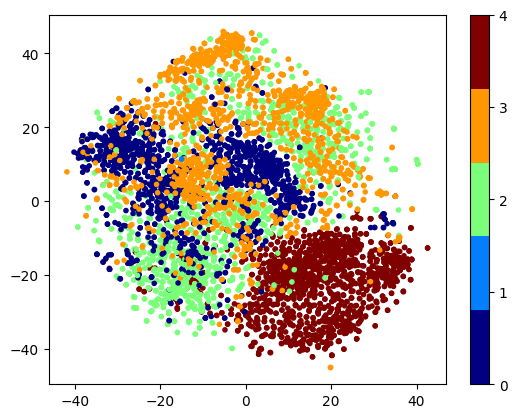

In [5]:
plot_classes(model)

In [6]:
N_WAY = 4  # Number of classes in a task
N_SHOT = 3  # Number of images per class in the support set
N_QUERY = 5  # Number of images per class in the query set
N_EVALUATION_TASKS = 100


test_sampler = TaskSampler(
    test_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_EVALUATION_TASKS
)

test_loader = DataLoader(
    test_set,
    batch_sampler=test_sampler,
    num_workers=2,
    pin_memory=False,
    collate_fn=test_sampler.episodic_collate_fn,
)

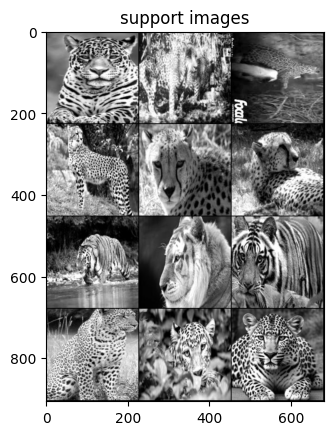

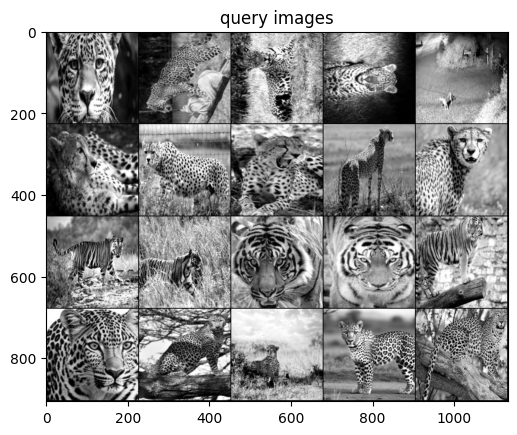

In [7]:
(
    example_support_images,
    example_support_labels,
    example_query_images,
    example_query_labels,
    example_class_ids,
) = next(iter(test_loader))

plot_images(example_support_images, "support images", images_per_row=N_SHOT)
plot_images(example_query_images, "query images", images_per_row=N_QUERY)

In [8]:
model.eval()
example_scores = model(
    example_support_images.cuda(),
    example_support_labels.cuda(),
    example_query_images.cuda(),
).detach()

_, example_predicted_labels = torch.max(example_scores.data, 1)

print("Ground Truth / Predicted")
for i in range(len(example_query_labels)):
    print(
        f"{test_set.class_names[example_class_ids[example_query_labels[i]]]} / {test_set.class_names[example_class_ids[example_predicted_labels[i]]]}"
    )

Ground Truth / Predicted
jaguar / leopard
jaguar / jaguar
jaguar / jaguar
jaguar / jaguar
jaguar / jaguar
guepard / guepard
guepard / guepard
guepard / guepard
guepard / guepard
guepard / leopard
tigre / tigre
tigre / tigre
tigre / jaguar
tigre / tigre
tigre / tigre
leopard / leopard
leopard / guepard
leopard / guepard
leopard / leopard
leopard / guepard


In [9]:
def evaluate_on_one_task(
    support_images: torch.Tensor,
    support_labels: torch.Tensor,
    query_images: torch.Tensor,
    query_labels: torch.Tensor,
) -> [int, int]:
    """
    Returns the number of correct predictions of query labels, and the total number of predictions.
    """
    return (
        torch.max(
            model(support_images.cuda(), support_labels.cuda(), query_images.cuda())
            .detach()
            .data,
            1,
        )[1]
        == query_labels.cuda()
    ).sum().item(), len(query_labels)


def evaluate(data_loader: DataLoader):
    # We'll count everything and compute the ratio at the end
    total_predictions = 0
    correct_predictions = 0


    model.eval()
    with torch.no_grad():
        for episode_index, (
            support_images,
            support_labels,
            query_images,
            query_labels,
            class_ids,
        ) in tqdm(enumerate(data_loader), total=len(data_loader)):

            correct, total = evaluate_on_one_task(
                support_images, support_labels, query_images, query_labels
            )

            total_predictions += total
            correct_predictions += correct

    print(
        f"Model tested on {len(data_loader)} tasks. Accuracy: {(100 * correct_predictions/total_predictions):.2f}%"
    )


evaluate(test_loader)

  7%|▋         | 7/100 [00:00<00:02, 31.05it/s]

100%|██████████| 100/100 [00:02<00:00, 44.75it/s]

Model tested on 100 tasks. Accuracy: 65.40%


In [10]:
N_TRAINING_EPISODES = 40000
N_VALIDATION_TASKS = 100

train_sampler = TaskSampler(
    train_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_TRAINING_EPISODES
)
train_loader = DataLoader(
    train_set,
    batch_sampler=train_sampler,
    num_workers=2,
    pin_memory=False,
    collate_fn=train_sampler.episodic_collate_fn,
)

In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


def fit(
    support_images: torch.Tensor,
    support_labels: torch.Tensor,
    query_images: torch.Tensor,
    query_labels: torch.Tensor,
) -> float:
    optimizer.zero_grad()
    classification_scores = model(
        support_images.cuda(), support_labels.cuda(), query_images.cuda()
    )

    loss = criterion(classification_scores, query_labels.cuda())
    loss.backward()
    optimizer.step()

    return loss.item()

In [12]:
log_update_frequency = 10

all_loss = []
model.train()
with tqdm(enumerate(train_loader), total=len(train_loader)) as tqdm_train:

    for episode_index, (
        support_images,
        support_labels,
        query_images,
        query_labels,
        _,
    ) in tqdm_train:
        loss_value = fit(support_images, support_labels, query_images, query_labels)
        all_loss.append(loss_value)

        if episode_index % log_update_frequency == 0:
            tqdm_train.set_postfix(loss=sliding_average(all_loss, log_update_frequency))

100%|██████████| 40000/40000 [26:11<00:00, 25.45it/s, loss=0.0978]


In [13]:
evaluate(test_loader)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:02<00:00, 46.74it/s]

Model tested on 100 tasks. Accuracy: 88.20%


In [14]:
torch.save(model.state_dict(), 'weights/model_few_shot_fine_tuned_resnet18.pth')

In [4]:
model.load_state_dict(
    torch.load(
        "weights/model_few_shot_fine_tuned.pth", map_location='cuda'
    )
)

<All keys matched successfully>

  0%|          | 0/6143 [00:00<?, ?it/s]/tmp/ipykernel_170095/2054819027.py:22: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  embedding_array = np.array(embedding.squeeze().cpu().detach())
100%|██████████| 6143/6143 [00:18<00:00, 331.45it/s]
/tmp/ipykernel_170095/2054819027.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  plt.scatter(vis_x, vis_y, c=labels, cmap=plt.cm.get_cmap("jet", num_classes), marker='.')


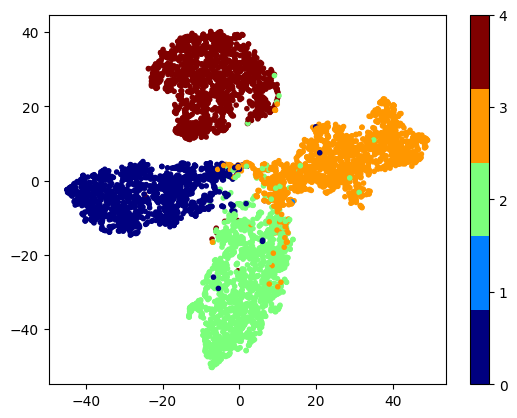

In [5]:
plot_classes(model)